### **Cell vs Cylinder Battery Classifier**  *Version 1*

### Imports

In [45]:
import tensorflow as tf
import os

# Avoid OOM Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[]

In [47]:
## Cleaning Datasets
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) # Checks if image can be read
            tip = imghdr.what(image_path) # Grabs extension of each file
            if tip not in image_exts:
                os.remove(image_path)
        except Exception as e:
            os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


In [46]:
import cv2 # For import issues: https://github.com/ultralytics/ultralytics/issues/1270
import imghdr

data_dir = 'data' # Currently data is google images for 'cylinder batteries' and 'coin cell batteries'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

## Test
# import matplotlib.pyplot as plt
# test_img = cv2.imread(os.path.join('data','coin','button-cell.jpg'))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # openCV uses BGR for some reason
# plt.show()


In [48]:
## Loading Data
import numpy as np
import matplotlib.pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('data') # Creates tf dataset (loads, resizes, batches data)
data_iterator = data.as_numpy_iterator() # Creates iterator for data object
batch = data_iterator.next() # Images and Labels. Shape = (32, 256, 256, 3)
    # might need to drop batch size for GPU cost

Found 146 files belonging to 2 classes.


2024-02-22 04:14:07.210986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:14:07.211052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


### Preprocess

In [49]:
## Scale Data [0,255] --> [0,1]
data = data.map(lambda x,y:(x/255, y)) 
    # data.map allows for in-line pipeline 
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

2024-02-22 04:14:08.453130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:14:08.453203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


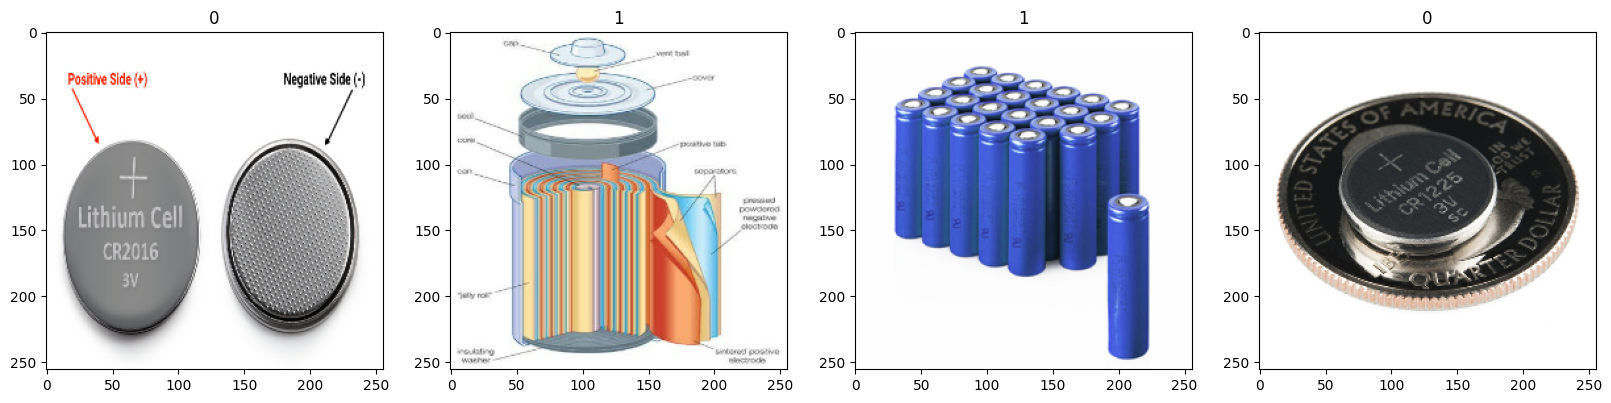

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

<h5><center>In the images above, 0: Coin Cell and 1: Cylinder Cell</center></h5>

In [51]:
## Split Data
num_batches = len(data)
train_size = int(num_batches*0.7) 
val_size = int(num_batches*0.2)
test_size = int(num_batches*0.1) 

while train_size + val_size + test_size < num_batches:
    test_size += 1

print(f"Train Size: {train_size}, Validation Size: {val_size}, Test Size: {test_size}")
print(f"Number of Batches: {num_batches}")

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Train Size: 3, Validation Size: 1, Test Size: 1
Number of Batches: 5


### **Deep Model**

#### Building DNN

In [52]:
from tensorflow.keras.models import Sequential # takes only one input as feed and expects one output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

## Adding layers sequentially
# Convulution Layers - using mainly relu activations 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # Input Layer
model.add(MaxPooling2D()) # Returns max value over (2,2) region, reducing image size by 1/2

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # reduces the input data into a single dimension instead of 2 dimensions.

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # One value as output (0 or 1)

In [54]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()

### Train

In [55]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# hist.history 

Epoch 1/20


2024-02-22 04:35:31.064507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:31.064567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.5521

2024-02-22 04:35:35.668403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:35.668917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 7s 2s/step - loss: 0.6989 - accuracy: 0.5521 - val_loss: 0.6671 - val_accuracy: 0.5625
Epoch 2/20


2024-02-22 04:35:36.768683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:36.769235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.7188

2024-02-22 04:35:40.735643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:40.736130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 5s 2s/step - loss: 0.5931 - accuracy: 0.7188 - val_loss: 0.5341 - val_accuracy: 0.6562
Epoch 3/20


2024-02-22 04:35:41.973698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:41.974219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.6562

2024-02-22 04:35:45.729576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:45.729639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 5s 2s/step - loss: 0.5487 - accuracy: 0.6562 - val_loss: 0.5819 - val_accuracy: 0.6562
Epoch 4/20


2024-02-22 04:35:46.656791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:46.656856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.8021

2024-02-22 04:35:49.829620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:49.829689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.4489 - accuracy: 0.8021 - val_loss: 0.3603 - val_accuracy: 0.8125
Epoch 5/20


2024-02-22 04:35:51.085458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:51.085672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8021

2024-02-22 04:35:54.316086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:54.316888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.4010 - accuracy: 0.8021 - val_loss: 0.4488 - val_accuracy: 0.6562
Epoch 6/20


2024-02-22 04:35:55.268850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:55.269075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8646

2024-02-22 04:35:58.761135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:35:58.761615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 5s 2s/step - loss: 0.3493 - accuracy: 0.8646 - val_loss: 0.3432 - val_accuracy: 0.8438
Epoch 7/20


2024-02-22 04:36:00.047503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:00.048017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.3320 - accuracy: 0.8542

2024-02-22 04:36:03.287158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:03.287982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.3320 - accuracy: 0.8542 - val_loss: 0.2498 - val_accuracy: 0.7812
Epoch 8/20


2024-02-22 04:36:04.229860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:04.230388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.7917

2024-02-22 04:36:07.532609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:07.532842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.3237 - accuracy: 0.7917 - val_loss: 0.2808 - val_accuracy: 0.8750
Epoch 9/20


2024-02-22 04:36:08.533993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:08.534043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8646

2024-02-22 04:36:11.619596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:11.619665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.2560 - accuracy: 0.8646 - val_loss: 0.1804 - val_accuracy: 0.9062
Epoch 10/20


2024-02-22 04:36:13.793681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:13.797943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9062

2024-02-22 04:36:17.321860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:17.322349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 5s 1s/step - loss: 0.1988 - accuracy: 0.9062 - val_loss: 0.1221 - val_accuracy: 1.0000
Epoch 11/20


2024-02-22 04:36:18.323718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:18.324223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9583

2024-02-22 04:36:21.602507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:21.603062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.1437 - accuracy: 0.9583 - val_loss: 0.1403 - val_accuracy: 0.9375
Epoch 12/20


2024-02-22 04:36:22.467091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:22.467300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9792

2024-02-22 04:36:25.602871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:25.602936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.1318 - accuracy: 0.9792 - val_loss: 0.1159 - val_accuracy: 0.9375
Epoch 13/20


2024-02-22 04:36:26.608077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:26.608148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 1.0000

2024-02-22 04:36:29.692876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:29.692936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0868 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 1.0000
Epoch 14/20


2024-02-22 04:36:30.983270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:30.983817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9688

2024-02-22 04:36:33.954374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:33.955033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0865 - accuracy: 0.9688 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 15/20


2024-02-22 04:36:35.002043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:35.002275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 1.0000

2024-02-22 04:36:38.073408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:38.073473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0662 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 0.9688
Epoch 16/20


2024-02-22 04:36:39.032180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:39.032240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9896

2024-02-22 04:36:42.139061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:42.139935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0505 - accuracy: 0.9896 - val_loss: 0.0401 - val_accuracy: 1.0000
Epoch 17/20


2024-02-22 04:36:43.470414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:43.470477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 1.0000

2024-02-22 04:36:46.558452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:46.558687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 18/20


2024-02-22 04:36:47.837267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:47.837770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9896

2024-02-22 04:36:50.917056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:50.917124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0382 - accuracy: 0.9896 - val_loss: 0.0541 - val_accuracy: 1.0000
Epoch 19/20


2024-02-22 04:36:52.157226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:52.157290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9792

2024-02-22 04:36:55.191472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:55.192252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0471 - accuracy: 0.9792 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 20/20


2024-02-22 04:36:56.502726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:56.503257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9792

2024-02-22 04:36:59.601306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 04:36:59.601797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


3/3 [==============================] - 4s 1s/step - loss: 0.0297 - accuracy: 0.9792 - val_loss: 0.1329 - val_accuracy: 0.9375


#### Plot Performance

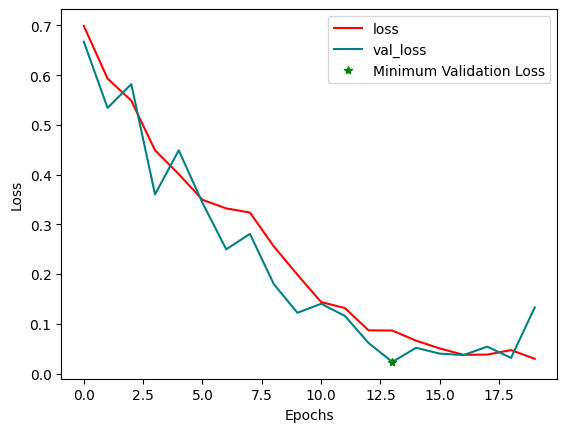

In [82]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label='loss')
plt.plot(hist.history['val_loss'], color = 'teal', label='val_loss')
plt.plot(np.argmin((hist.history['val_loss'])), min(hist.history['val_loss']), color = 'green', label = 'Minimum Validation Loss', marker='*', linestyle = '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()

*Model is overfitting - this will be key in actual sorting*

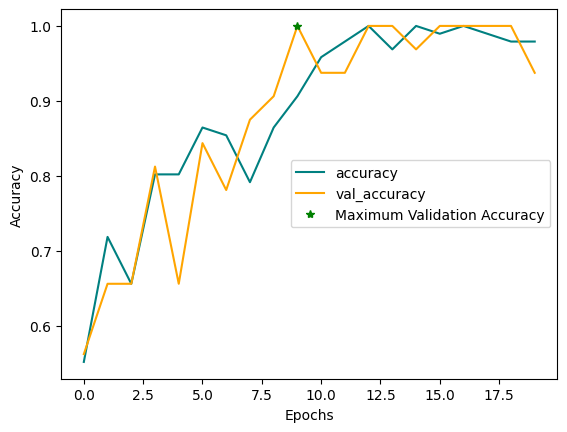

In [88]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(np.argmax((hist.history['val_accuracy'])), max(hist.history['val_accuracy']), color = 'green', label = 'Maximum Validation Accuracy', marker='*', linestyle = '')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="right")
plt.show()

### Evaluate and Test

In [92]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): # testing data
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

print(f"Precision: {pre.result()}")
print(f"Recall: {re.result()}") 
print(f"Accuracy: {acc.result()}")

2024-02-22 05:00:51.506605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-22 05:00:51.507090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


1/1 [==============================] - 0s 172ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


### Self Testing w/ own images

1/1 [==============================] - 0s 44ms/step
[[0.03248088]]
1/1 [==============================] - 0s 31ms/step
[[0.8858608]]


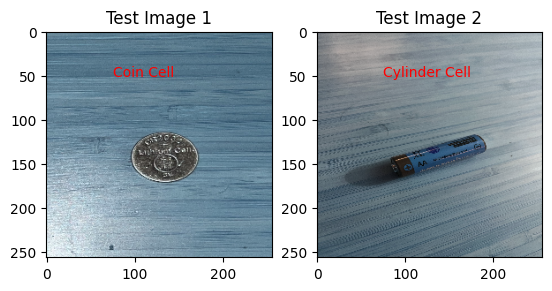

In [110]:
img1 = cv2.imread(os.path.join('data','user-test', 'test1.jpeg'))
img2 = cv2.imread(os.path.join('data','user-test', 'test2.jpeg'))
resize1 = tf.image.resize(img1, (256,256))
resize2 = tf.image.resize(img2, (256,256))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(resize1.numpy().astype(int))
axarr[0].set_title('Test Image 1')
axarr[1].imshow(resize2.numpy().astype(int))
axarr[1].set_title('Test Image 2')

yhat1 = model.predict(np.expand_dims(resize1/255,0))
print(yhat1)
label1 = 'Coin Cell' if yhat1 < 0.5 else 'Cylinder Cell'
yhat2 = model.predict(np.expand_dims(resize2/255,0))
print(yhat2)
label2 = 'Coin Cell' if yhat2 < 0.5 else 'Cylinder Cell'

axarr[0].text(75, 50, label1, color='red')
axarr[1].text(75, 50, label2, color='red')

plt.show()
